In [25]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from datetime import datetime
import keras
from keras import layers, ops
import numpy as np
import pandas as pd
import time

In [26]:
# Hyperparameters
dataset_name = "mnist"
dataset_repetitions = 5
num_epochs = 50
image_size = 64
batch_size = 64
latent_dim = 100

# WGAN specific
critic_iterations = 5  # Train critic 5 times per generator update
clip_value = 0.01  # Weight clipping value for WGAN
learning_rate = 5e-5  # Lower learning rate for WGAN stability

In [27]:
def preprocess_image(data):
    """Preprocess image: resize, convert to RGB, normalize to [0, 1]"""
    image = data["image"]

    # MNIST is 28x28 grayscale, convert to 3 channels
    if len(image.shape) == 2 or image.shape[-1] == 1:
        image = tf.image.grayscale_to_rgb(image)

    # MNIST is already 28x28, but resize if needed
    image = tf.image.resize(image, size=[image_size, image_size], antialias=True)
    return ops.clip(image / 255.0, 0.0, 1.0)


def prepare_dataset(split):
    """Prepare dataset with preprocessing and batching"""
    return (
        tfds.load(dataset_name, split=split, shuffle_files=True)
        .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        .cache()
        .repeat(dataset_repetitions)
        .shuffle(10 * batch_size)
        .batch(batch_size, drop_remainder=True)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

# Use test split for KID validation (MNIST has train/test)
kid_val_ds = prepare_dataset("test")
kid_val_iter = iter(kid_val_ds)

In [28]:
class KIDMetric(keras.metrics.Metric):
    """
    Unbiased KID (Kernel Inception Distance) with polynomial kernel of degree 3.
    KID = E[k(x,x')] + E[k(y,y')] - 2E[k(x,y)], x=real features, y=fake features
    Uses InceptionV3 (avg pooled) as the encoder.
    """
    def __init__(self, image_size=64, kid_image_size=299, name="kid", **kwargs):
        super().__init__(name=name, **kwargs)
        self.kid_tracker = keras.metrics.Mean(name="kid_tracker")
        self.kid_image_size = kid_image_size

        # Inception encoder: [0,1] -> [0,255] -> preprocess_input -> InceptionV3 -> GAP(2048)
        self.encoder = keras.Sequential(
            [
                keras.Input(shape=(image_size, image_size, 3)),
                layers.Rescaling(255.0),
                layers.Resizing(kid_image_size, kid_image_size),
                layers.Lambda(keras.applications.inception_v3.preprocess_input),
                keras.applications.InceptionV3(
                    include_top=False,
                    input_shape=(kid_image_size, kid_image_size, 3),
                    weights="imagenet",
                ),
                layers.GlobalAveragePooling2D(),
            ],
            name="inception_encoder",
        )

    def polynomial_kernel(self, feats1, feats2):
        # k(x,y) = (xᵀy / d + 1)^3
        d = ops.cast(ops.shape(feats1)[1], "float32")
        return (feats1 @ ops.transpose(feats2) / d + 1.0) ** 3.0

    def _unbiased_mmd(self, f_real, f_fake):
        # Gram matrices
        k_xx = self.polynomial_kernel(f_real, f_real)
        k_yy = self.polynomial_kernel(f_fake, f_fake)
        k_xy = self.polynomial_kernel(f_real, f_fake)

        m = tf.shape(f_real)[0]
        n = tf.shape(f_fake)[0]

        # remove diagonal terms for unbiased estimate
        sum_k_xx = (tf.reduce_sum(k_xx) - tf.reduce_sum(tf.linalg.diag_part(k_xx))) / tf.cast(m * (m - 1), tf.float32)
        sum_k_yy = (tf.reduce_sum(k_yy) - tf.reduce_sum(tf.linalg.diag_part(k_yy))) / tf.cast(n * (n - 1), tf.float32)
        sum_k_xy = tf.reduce_sum(k_xy) / tf.cast(m * n, tf.float32)

        return sum_k_xx + sum_k_yy - 2.0 * sum_k_xy

    def update_state(self, real_images, generated_images, sample_weight=None):
        # Expect inputs in [0,1]. If your generator outputs [-1,1] via tanh,
        # convert: gen = (gen + 1.0) / 2.0 before calling update_state.
        f_real = self.encoder(real_images, training=False)
        f_fake = self.encoder(generated_images, training=False)
        kid = self._unbiased_mmd(f_real, f_fake)
        self.kid_tracker.update_state(kid)

    def result(self):
        return self.kid_tracker.result()

    def reset_state(self):
        self.kid_tracker.reset_state()

# --- KID generation helper ---
latent_dim = 100  # keep whatever your WGAN uses

def gen_fake_batch(generator, batch_size):
    z = tf.random.normal(shape=(batch_size, latent_dim))
    fake = generator(z, training=False)
    # Map to [0,1] if your generator uses tanh output in [-1,1]
    if fake.dtype.is_floating:
        # Heuristic: if values look like tanh, rescale
        # (safe to always rescale if you know you're using tanh)
        fake = (fake + 1.0) / 2.0
    return tf.clip_by_value(fake, 0.0, 1.0)


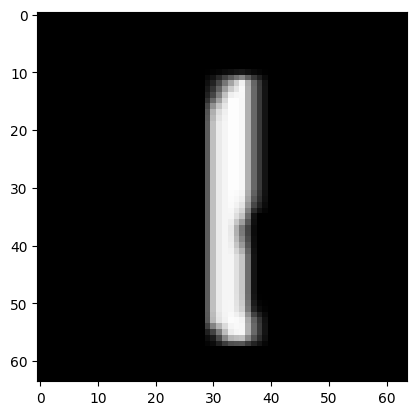

In [29]:
# Load datasets - use train split for MNIST
train_dataset = prepare_dataset("train")
# Print out a sample of the dataset
for image in train_dataset.take(1):
    plt.imshow(image[0].numpy())
    plt.show()
    break


def build_generator(latent_dim, image_size):
    """Build generator network"""
    model = keras.Sequential([
        keras.Input(shape=(latent_dim,)),
        layers.Dense(4 * 4 * 256, use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((4, 4, 256)),

        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        layers.Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.Activation('tanh'),  # Output in [-1, 1]
    ], name='generator')
    return model


def build_critic(image_size):
    """WGAN-GP critic: no BatchNorm/Dropout; plain conv stack."""
    L = keras.layers
    x = inputs = keras.Input(shape=(image_size, image_size, 3))
    nf = 64
    # 64 -> 32
    x = L.Conv2D(nf, 4, strides=2, padding="same", kernel_initializer="he_normal")(x)
    x = L.LeakyReLU(0.2)(x)
    # 32 -> 16
    x = L.Conv2D(nf*2, 4, strides=2, padding="same", kernel_initializer="he_normal")(x)
    x = L.LeakyReLU(0.2)(x)
    # 16 -> 8
    x = L.Conv2D(nf*4, 4, strides=2, padding="same", kernel_initializer="he_normal")(x)
    x = L.LeakyReLU(0.2)(x)
    # 8 -> 4
    x = L.Conv2D(nf*8, 4, strides=2, padding="same", kernel_initializer="he_normal")(x)
    x = L.LeakyReLU(0.2)(x)

    x = L.Flatten()(x)
    out = L.Dense(1)(x)  # linear score
    return keras.Model(inputs, out, name="critic")

# Gradient penalty hyperparam
gp_lambda = 10.0

def gradient_penalty(critic, real, fake):
    """WGAN-GP gradient penalty on random interpolates"""
    batch = tf.shape(real)[0]
    epsilon = tf.random.uniform([batch, 1, 1, 1], 0.0, 1.0)
    x_hat = epsilon * real + (1.0 - epsilon) * fake
    with tf.GradientTape() as gp_tape:
        gp_tape.watch(x_hat)
        pred = critic(x_hat, training=True)
    grads = gp_tape.gradient(pred, x_hat)  # ∂D/∂x_hat
    grads = tf.reshape(grads, [batch, -1])
    grad_norm = tf.norm(grads, axis=1)
    gp = tf.reduce_mean((grad_norm - 1.0) ** 2)
    return gp


def generate_images(generator, epoch, num_images=16):
    """Generate and save sample images"""
    # Generate random noise
    noise = tf.random.normal((num_images, latent_dim))

    # Generate images
    generated_images = G_ema(noise, training=False)

    # Convert from [-1, 1] to [0, 1] for display
    generated_images = (generated_images + 1) / 2.0
    generated_images = ops.clip(generated_images, 0.0, 1.0)

    # Create output directory
    output_dir = "generated_images"
    os.makedirs(output_dir, exist_ok=True)

    # Plot grid
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i].numpy())
        ax.axis('off')
    plt.tight_layout()

    # Save figure
    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    filename = f"epoch_{epoch:03d}_{timestamp}.png"
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath)
    plt.close()

    print(f"Saved generated images to {filepath}")

# Helper function for ema
def update_ema(G_src, G_tgt, decay=0.999):
    """G_tgt = EMA(G_src)  (in-place)"""
    src_w = G_src.get_weights()
    tgt_w = G_tgt.get_weights()
    new_w = []
    for w_ema, w in zip(tgt_w, src_w):
        new_w.append(decay * w_ema + (1.0 - decay) * w)
    G_tgt.set_weights(new_w)


In [ ]:
# Build models
generator = build_generator(latent_dim, image_size)
critic = build_critic(image_size)

# --- EMA setup (place right after you build `generator`) ---
G_ema = keras.models.clone_model(generator)
G_ema.set_weights(generator.get_weights())
ema_decay = 0.999  # try 0.999 for 50 epochs; 0.9995 if you train longer

# Optimizers - Adam instead of RMSProp
generator_optimizer = keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.0, beta_2=0.9)
critic_optimizer    = keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.0, beta_2=0.9)

print("Generator summary:")
generator.summary()
print("\nCritic summary:")
critic.summary()


# Training step
@tf.function
def train_step(real_images):
    batch_size = tf.shape(real_images)[0]
    real_images = real_images * 2.0 - 1.0  # [-1,1]

    # --- Critic updates ---
    for _ in range(critic_iterations):
        noise = tf.random.normal((batch_size, latent_dim))
        fake_images = generator(noise, training=True)  # training=True OK

        with tf.GradientTape() as tape:
            real_scores = critic(real_images, training=True)
            fake_scores = critic(fake_images, training=True)

            wasserstein = tf.reduce_mean(real_scores) - tf.reduce_mean(fake_scores)
            gp = gradient_penalty(critic, real_images, fake_images)
            # We minimize the negative of wasserstein + GP term
            critic_loss = -(wasserstein) + gp_lambda * gp

        grads = tape.gradient(critic_loss, critic.trainable_weights)
        critic_optimizer.apply_gradients(zip(grads, critic.trainable_weights))

    # --- Generator update ---
    noise = tf.random.normal((batch_size, latent_dim))
    with tf.GradientTape() as tape:
        fake_images = generator(noise, training=True)
        fake_scores = critic(fake_images, training=True)  # train mode since no BN/Dropout
        generator_loss = -tf.reduce_mean(fake_scores)
    g_grads = tape.gradient(generator_loss, generator.trainable_weights)
    generator_optimizer.apply_gradients(zip(g_grads, generator.trainable_weights))

    # For logging, you might also return components:
    return critic_loss, generator_loss, wasserstein, gp


# --- Initialize KID metric ---
kid_metric = KIDMetric(image_size=image_size, kid_image_size=299)
kid_history = []

# Create validation iterator (already defined above)
kid_val_iter = iter(kid_val_ds)



# Training loop + KID eval (per epoch)
print("\nStarting training...")

# Start overall timing
training_start_time = time.time()

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    # Start epoch timing
    epoch_start_time = time.time()

    epoch_critic_loss = []
    epoch_generator_loss = []

    for step, batch_images in enumerate(train_dataset):
        critic_loss, generator_loss, W, gp_val = train_step(batch_images)
        update_ema(generator, G_ema, decay=ema_decay)

        epoch_critic_loss.append(critic_loss.numpy())
        epoch_generator_loss.append(generator_loss.numpy())

        if step % 100 == 0:
            print(
                f"  Step {step}: D_loss={critic_loss:.4f} G_loss={generator_loss:.4f} "
                f"W={W:.4f} GP={gp_val:.4f}"
            )

    # Epoch training time
    epoch_train_time = time.time() - epoch_start_time

    # Print epoch averages
    avg_critic_loss = np.mean(epoch_critic_loss)
    avg_generator_loss = np.mean(epoch_generator_loss)
    print(
        f"  Epoch {epoch + 1} - Avg Critic Loss: {avg_critic_loss:.4f}, "
        f"Avg Generator Loss: {avg_generator_loss:.4f}"
    )

    # --------- KID EVAL (every epoch) ----------
    print(f"  Computing KID for epoch {epoch + 1}...")
    kid_start_time = time.time()

    # Get a real batch from validation split
    try:
        real_eval = next(kid_val_iter)
    except StopIteration:
        kid_val_iter = iter(kid_val_ds)
        real_eval = next(kid_val_iter)

    # Generate a fake batch using EMA generator
    fake_eval = gen_fake_batch(G_ema, tf.shape(real_eval)[0])

    # Update KID and log it
    kid_metric.update_state(real_eval, fake_eval)
    current_kid = float(kid_metric.result().numpy())
    kid_eval_time = time.time() - kid_start_time

    kid_history.append({
        "epoch": int(epoch + 1),
        "kid": current_kid,
        "epoch_train_time_sec": epoch_train_time,
        "kid_eval_time_sec": kid_eval_time,
        "avg_critic_loss": float(avg_critic_loss),
        "avg_generator_loss": float(avg_generator_loss)
    })

    print(f"  [KID] Epoch {epoch+1}: KID={current_kid:.6f} (eval time: {kid_eval_time:.2f}s)")
    kid_metric.reset_state()
    # ------------------------------------------------------

    # Generate and save sample images every epoch
    sampling_start_time = time.time()
    generate_images(generator, epoch + 1)
    sampling_time = time.time() - sampling_start_time

    # Update history with sampling time
    kid_history[-1]["sampling_time_sec"] = sampling_time

    print(f"  Epoch time: {epoch_train_time:.2f}s, Sampling time: {sampling_time:.2f}s")

Generator summary:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 4096)           │       409,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_196         │ (None, 4096)           │        16,384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_16 (LeakyReLU)      │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 8, 8, 128)      │       524,288 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_197         │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_17 (LeakyReLU)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 16, 16, 64)     │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_198         │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_18 (LeakyReLU)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_10             │ (None, 32, 32, 32)     │        32,768 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_199         │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_19 (LeakyReLU)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_11             │ (None, 64, 64, 3)      │         1,536 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_190 (Activation)     │ (None, 64, 64, 3)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,116,544 (4.26 MB)

 Trainable params: 1,107,904 (4.23 MB)

 Non-trainable params: 8,640 (33.75 KB)


Critic summary:


Model: "critic"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_196 (Conv2D)             │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_20 (LeakyReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_197 (Conv2D)             │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_21 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_198 (Conv2D)             │ (None, 8, 8, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_22 (LeakyReLU)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_199 (Conv2D)             │ (None, 4, 4, 512)      │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_23 (LeakyReLU)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,764,737 (10.55 MB)

 Trainable params: 2,764,737 (10.55 MB)

 Non-trainable params: 0 (0.00 B)


Starting training...

Epoch 1/50
  Step 0: D_loss=-24.7471 G_loss=-2.3814 W=26.3818 GP=0.1635
  Step 100: D_loss=-129.5925 G_loss=-168.9009 W=189.2859 GP=5.9693
  Step 200: D_loss=-56.5732 G_loss=-149.4344 W=79.8400 GP=2.3267
  Step 300: D_loss=-37.3708 G_loss=-63.6625 W=52.2541 GP=1.4883
  Step 400: D_loss=-35.1173 G_loss=-37.5830 W=48.8512 GP=1.3734
  Step 500: D_loss=-33.0307 G_loss=-16.1452 W=45.8702 GP=1.2839
  Step 600: D_loss=-31.1755 G_loss=-25.2782 W=42.6112 GP=1.1436
  Step 700: D_loss=-30.2888 G_loss=-20.7902 W=40.5359 GP=1.0247
  Step 800: D_loss=-30.6969 G_loss=-14.8456 W=39.8948 GP=0.9198
  Step 900: D_loss=-29.0923 G_loss=-0.8313 W=40.0893 GP=1.0997
  Step 1000: D_loss=-26.8331 G_loss=-7.5356 W=34.3407 GP=0.7508
  Step 1100: D_loss=-26.7984 G_loss=-11.7093 W=34.2616 GP=0.7463
  Step 1200: D_loss=-24.2001 G_loss=1.9123 W=32.7025 GP=0.8502


In [ ]:
# Calculate total training time
total_training_time = time.time() - training_start_time
print(f"\nTotal training time: {total_training_time:.2f} seconds ({total_training_time/60:.2f} minutes)")

# Save models
print("\nSaving models...")
os.makedirs("checkpoints", exist_ok=True)
generator.save_weights("checkpoints/wgan_generator.weights.h5")
critic.save_weights("checkpoints/wgan_critic.weights.h5")
print("Models saved!")

# ---- Save metrics history to compare with DDIM ----
import json

# Save as JSON (full data)
with open("wgan_metrics.json", "w") as f:
    json.dump(kid_history, f, indent=2)

# Save as CSV with specific column order: epoch, KID, training time, sampling time
df_metrics = pd.DataFrame(kid_history)
# Reorder columns for the CSV
df_csv = df_metrics[['epoch', 'kid', 'epoch_train_time_sec', 'sampling_time_sec']].copy()
# Rename columns for clarity
df_csv.columns = ['Epoch', 'KID', 'Training_Time_Sec', 'Sampling_Time_Sec']
df_csv.to_csv("wgan_metrics.csv", index=False)

# Print summary statistics
print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"Total training time: {total_training_time:.2f}s ({total_training_time/60:.2f} min)")
print(f"Average epoch time: {df_metrics['epoch_train_time_sec'].mean():.2f}s")
print(f"Average sampling time: {df_metrics['sampling_time_sec'].mean():.2f}s")
print(f"Average KID eval time: {df_metrics['kid_eval_time_sec'].mean():.2f}s")
print(f"\nFinal KID: {df_metrics['kid'].iloc[-1]:.6f}")
print(f"Best KID: {df_metrics['kid'].min():.6f} (Epoch {df_metrics.loc[df_metrics['kid'].idxmin(), 'epoch']:.0f})")
print("="*60)
print(f"\nMetrics saved to:")
print(f"  - wgan_metrics.csv")
print(f"  - wgan_metrics.json")
print("\nTraining complete!")

In [ ]:
# Generate final high-quality images after training
print("Generating final images...")

# Create output directory
final_output_dir = "final_generated_images"
os.makedirs(final_output_dir, exist_ok=True)

# Generate multiple sets of images
num_sets = 5  # Generate 5 sets of 16 images each
num_images_per_set = 16

for set_idx in range(num_sets):
    # Generate random noise
    noise = tf.random.normal((num_images_per_set, latent_dim))

    # Generate images using EMA generator (best quality)
    generated_images = G_ema(noise, training=False)

    # Convert from [-1, 1] to [0, 1] for display
    generated_images = (generated_images + 1) / 2.0
    generated_images = ops.clip(generated_images, 0.0, 1.0)

    # Plot grid (4x4)
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i].numpy())
        ax.axis('off')
    plt.tight_layout()

    # Save figure
    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    filename = f"final_set_{set_idx+1}_{timestamp}.png"
    filepath = os.path.join(final_output_dir, filename)
    plt.savefig(filepath, dpi=150, bbox_inches='tight')
    plt.close()

    print(f"  Saved set {set_idx+1}/{num_sets} to {filepath}")

print(f"\n✓ Generated {num_sets} sets of images in '{final_output_dir}/' folder")
print(f"Total images: {num_sets * num_images_per_set} images")


In [ ]:
    !zip -r generated_images.zip generated_images

In [ ]:
    from google.colab import files
    files.download('generated_images.zip')

In [ ]:
    !zip -r final_generated_images.zip final_generated_images

In [ ]:
  files.download('final_generated_images.zip')